## 3. Getting Started with Neural Networks

### Predicting House Prices: A Regression Example

In the housing prices problem, the goal is to predict a value instead of a discrete label. This is an example of a regression problem, and is different from the classification problem we had in the past examples.

In [11]:
from keras.datasets import boston_housing

import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from keras.utils.np_utils import to_categorical
from keras import models
from keras import layers

import matplotlib.pyplot as plt

In [2]:
##########
# Ingestion
##########
(train_data, train_labels), (test_data, test_labels) = boston_housing.load_data()

The data now consists of 404 training examples and 102 test samples, each with 13 numericlal features.

In [4]:
# For testing
# print([td[:] for td in train_data[0:3]])
# print(train_labels[0:3])

[array([  1.23247,   0.     ,   8.14   ,   0.     ,   0.538  ,   6.142  ,
        91.7    ,   3.9769 ,   4.     , 307.     ,  21.     , 396.9    ,
        18.72   ]), array([2.1770e-02, 8.2500e+01, 2.0300e+00, 0.0000e+00, 4.1500e-01,
       7.6100e+00, 1.5700e+01, 6.2700e+00, 2.0000e+00, 3.4800e+02,
       1.4700e+01, 3.9538e+02, 3.1100e+00]), array([4.89822e+00, 0.00000e+00, 1.81000e+01, 0.00000e+00, 6.31000e-01,
       4.97000e+00, 1.00000e+02, 1.33250e+00, 2.40000e+01, 6.66000e+02,
       2.02000e+01, 3.75520e+02, 3.26000e+00])]
[15.2 42.3 50. ]


Before we fit the data into the network, we perform feature scaling. 

In [9]:
##########
# Preprocessing
##########
sc = StandardScaler()
x_train = sc.fit_transform(train_data)
x_test = sc.transform(test_data)

num_features = x_train.shape[1]

As the number of samples is small, we use a small network with two hidden layers, each with 64 units. This will help to mitigate overfitting.

This model ends with a single unit and no activation. This is typical for a scalar regression problem (predict only a scalar value). 

In [10]:
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(num_features,)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    
    return model

Now, instead of train-test split, we will use k-fold cross validation. In this case, k is 4. Note that we are trying to grid search on no. of epochs to find the best value.

In [17]:
kf = KFold(n_splits=4, random_state=0, shuffle=True)
f = 1
mae_histories = []
num_epochs = 100

##########
# Train
##########
for ftrain_index, ftest_index in kf.split(x_train):
    print("Processing fold " + str(f))
    
    f_xtrain = x_train[ftrain_index]
    f_xtest = x_train[ftest_index]
    f_ytrain = train_labels[ftrain_index]
    f_ytest = train_labels[ftest_index]
    
    model = build_model()
    history = model.fit(f_xtrain, f_ytrain, 
                        validation_data=(f_xtest, f_ytest), 
                        epochs = num_epochs, batch_size=1, 
                        verbose=0)
    mae_histories.append(history)
    f +=1

Processing fold 1
Processing fold 2
Processing fold 3
Processing fold 4


In [32]:
# Performance evaluation using MAE
print([np.mean(h.history['val_mae']) for h in mae_histories])
np.mean([np.mean(h.history['val_mae']) for h in mae_histories])

[2.457387135028839, 2.491862704753876, 2.3064396286010744, 2.643530614376068]


2.4748050206899643

The different runs do show different validation scores. Let's now try with 500 epochs.

In [34]:
##########
# Train
##########

num_epochs = 500
f = 1
for ftrain_index, ftest_index in kf.split(x_train):
    print("Processing fold " + str(f))
    
    f_xtrain = x_train[ftrain_index]
    f_xtest = x_train[ftest_index]
    f_ytrain = train_labels[ftrain_index]
    f_ytest = train_labels[ftest_index]
    
    model = build_model()
    history = model.fit(f_xtrain, f_ytrain, 
                        validation_data=(f_xtest, f_ytest), 
                        epochs = num_epochs, batch_size=1, 
                        verbose=0)
    mae_histories.append(history)
    f +=1

Processing fold 1
Processing fold 2
Processing fold 3
Processing fold 4


In [41]:
# Plot the MAE histories across the different folds
mae_histories2 = [h.history['val_mae'] for h in mae_histories[4:]]


In [56]:
avg_mae_histories = []
for (m1, m2, m3, m4) in zip(mae_histories2[0], mae_histories2[1], mae_histories2[2], mae_histories2[3]):
    avg_mae_histories.append(np.mean(np.array([m1,m2,m3,m4])))

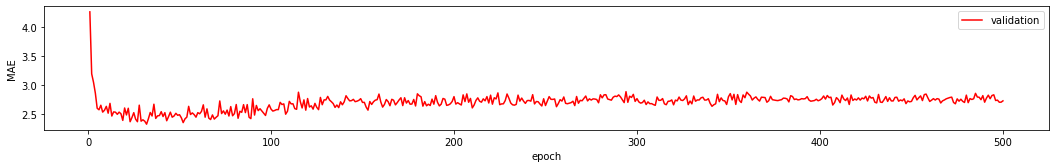

In [64]:
metrics_df = pd.DataFrame({'val_mae' : avg_mae_histories})
metrics_df['epoch'] = metrics_df.index+1

fig = plt.figure(figsize=(18,5))
ax = fig.add_subplot(211)
metrics_df.plot(kind='line', x='epoch', y='val_mae', ax=ax, label='validation', color='red',)
ax.set_ylabel("MAE")
plt.show()

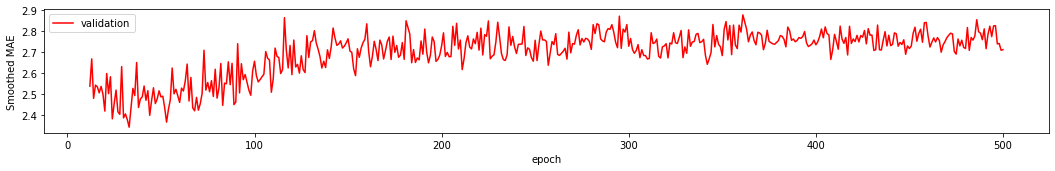

In [81]:
metrics_df2 = metrics_df.iloc[10:].copy()
metrics_df2['val_mae_tm1'] = metrics_df2['val_mae'].shift(1)
metrics_df2['val_mae_ewma'] = metrics_df2['val_mae'] * 0.1 + metrics_df2['val_mae_tm1']*0.9
metrics_df2
fig = plt.figure(figsize=(18,5))
ax = fig.add_subplot(211)
metrics_df2.plot(kind='line', x='epoch', y='val_mae_ewma', ax=ax, label='validation', color='red',)
ax.set_ylabel("Smoothed MAE")
plt.show()

From here we can see that the validation MAE stops improving after about 80 epochs. So we use this as the tuned parameter.

In [82]:
final_model = build_model()
final_model.fit(f_xtrain, f_ytrain, 
                        validation_data=(f_xtest, f_ytest), 
                        epochs = 80, batch_size=1, 
                        verbose=0)

In [84]:
test_mse_score, test_mae_score = final_model.evaluate(test_data, test_labels)

102/102 [==============================] - 0s 64us/step


In [85]:
print(test_mae_score)

1903.668701171875


In [88]:
##########
# Predict
##########
final_model.predict(test_data[:5])

array([[2080.959 ],
       [1908.7532],
       [1749.3546],
       [1731.4608],
       [1717.7333]], dtype=float32)